<a href="https://colab.research.google.com/github/Ashikasunil/CV-project/blob/main/Copy_of_Final_QRC_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import zipfile
import os
import re

In [ ]:
# --- Step 2: Unzip them ---
def unzip_file(zip_name, extract_to):
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

unzip_file("/content/images_new (1).zip", "images")
unzip_file("/content/mask_new (1).zip", "masks")

In [ ]:
# Re-check filenames
image_dir = "images/images_new"
mask_dir = "masks/mask_new"

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

# Normalize names (strip spaces, lower case, etc.)
image_files_clean = [f.strip().lower() for f in image_files]
mask_files_clean = [f.strip().lower() for f in mask_files]

# Find matching filenames
matched = list(set(image_files_clean) & set(mask_files_clean))

print(f"Matching files: {len(matched)}")
print(f"Example matches: {matched[:5]}")

# Show mismatches (first 5)
unmatched = list(set(image_files_clean) - set(mask_files_clean))
print(f"\nImage files without matching mask: {len(unmatched)}")
print(f"Examples: {unmatched[:5]}")

Matching files: 1224
Example matches: ['malignant case (3)croppedresizedresizedn.jpg', 'malignant case (430)croppedresized.jpg', 'malignant case (307)croppedresized.jpg', 'malignant case (102)croppedresizedvflip.jpg', 'malignant case (300)croppedresizedhflip.jpg']

Image files without matching mask: 0
Examples: []


In [ ]:
# Create mapping from normalized name to full path
image_dict = {f.strip().lower(): os.path.join(image_dir, f) for f in image_files}
mask_dict = {f.strip().lower(): os.path.join(mask_dir, f) for f in mask_files}

# Find common keys (normalized filenames)
common_keys = set(image_dict.keys()) & set(mask_dict.keys())

# Create usable pairs
pairs = [(image_dict[k], mask_dict[k]) for k in common_keys]

print(f"✅ Final usable image-mask pairs: {len(pairs)}")

✅ Final usable image-mask pairs: 1224


In [ ]:
!pip install timm opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Transforms
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Dataset
class LungNoduleDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = (mask > 0.5).float()
        return image, mask

In [ ]:
image_path = "/content/images/images_new"
mask_path = "/content/masks/mask_new"

In [ ]:
dataset = LungNoduleDataset(image_path, mask_path, image_transform, mask_transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import timm

# --- QFC ---
class QuantumFourierConv(nn.Module):
    def __init__(self, channels):
        super(QuantumFourierConv, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        real = self.conv1(x)
        imag = self.conv2(x)
        out = torch.sqrt(real**2 + imag**2)
        return out

# --- ResCaps ---
class ResidualCapsuleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualCapsuleBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        skip = self.skip(x)
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        return F.relu(x + skip)

# --- ADSC ---
class ADSCBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ADSCBlock, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return F.relu(x)

# --- QRC-U-Net Full Architecture ---
class QRC_UNet(nn.Module):
    def __init__(self):
        super(QRC_UNet, self).__init__()
        self.encoder = timm.create_model('mobilevit_xxs', pretrained=True, features_only=True)
        enc_channels = self.encoder.feature_info.channels()  # e.g., [16, 24, 48, 64, 320]

        self.qfc = QuantumFourierConv(enc_channels[-1])
        self.rescaps = ResidualCapsuleBlock(enc_channels[-1], 256)

        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.adsc1 = ADSCBlock(128 + enc_channels[3], 128)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.adsc2 = ADSCBlock(64 + enc_channels[2], 64)

        self.up3 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.adsc3 = ADSCBlock(32 + enc_channels[1], 32)

        self.up4 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.adsc4 = ADSCBlock(16 + enc_channels[0], 16)

        self.final_conv = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        e1, e2, e3, e4, e5 = self.encoder(x)
        x = self.qfc(e5)
        x = self.rescaps(x)

        x = self.up1(x)
        x = self.adsc1(torch.cat([x, e4], dim=1))

        x = self.up2(x)
        x = self.adsc2(torch.cat([x, e3], dim=1))

        x = self.up3(x)
        x = self.adsc3(torch.cat([x, e2], dim=1))

        x = self.up4(x)
        x = self.adsc4(torch.cat([x, e1], dim=1))

        x = self.final_conv(x)
        return torch.sigmoid(x)

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        return 1 - (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)

bce = nn.BCELoss()
dice = DiceLoss()

def loss_fn(preds, targets):
    return 0.5 * bce(preds, targets) + 0.5 * dice(preds, targets)

def compute_dice(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        return 1 - (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)

bce = nn.BCELoss()
dice = DiceLoss()

def loss_fn(preds, targets):
    return 0.5 * bce(preds, targets) + 0.5 * dice(preds, targets)

def compute_dice(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

In [ ]:
def train_model(model, dataloader, optimizer, loss_fn, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_dice = 0

        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            outputs = F.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)

            loss = loss_fn(outputs, masks)
            dice_score = compute_dice(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_dice += dice_score

        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(dataloader):.4f} | Dice: {total_dice/len(dataloader):.4f}")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QRC_UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_model(model, dataloader, optimizer, loss_fn, device, epochs=30)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/5.14M [00:00<?, ?B/s]

Epoch 1/30 | Loss: 0.6341 | Dice: 0.0183
Epoch 2/30 | Loss: 0.4235 | Dice: 0.2133
Epoch 3/30 | Loss: 0.2551 | Dice: 0.6781
Epoch 4/30 | Loss: 0.1493 | Dice: 0.8016
Epoch 5/30 | Loss: 0.1140 | Dice: 0.8371
Epoch 6/30 | Loss: 0.1010 | Dice: 0.8553
Epoch 7/30 | Loss: 0.0938 | Dice: 0.8641
Epoch 8/30 | Loss: 0.0891 | Dice: 0.8706
Epoch 9/30 | Loss: 0.0886 | Dice: 0.8686
Epoch 10/30 | Loss: 0.0828 | Dice: 0.8775
Epoch 11/30 | Loss: 0.0808 | Dice: 0.8794
Epoch 12/30 | Loss: 0.0801 | Dice: 0.8790
Epoch 13/30 | Loss: 0.0753 | Dice: 0.8873
Epoch 14/30 | Loss: 0.0739 | Dice: 0.8884
Epoch 15/30 | Loss: 0.0738 | Dice: 0.8875
Epoch 16/30 | Loss: 0.0712 | Dice: 0.8916
Epoch 17/30 | Loss: 0.0707 | Dice: 0.8933
Epoch 18/30 | Loss: 0.0716 | Dice: 0.8913
Epoch 19/30 | Loss: 0.0686 | Dice: 0.8952
Epoch 20/30 | Loss: 0.0676 | Dice: 0.8973
Epoch 21/30 | Loss: 0.0664 | Dice: 0.8986
Epoch 22/30 | Loss: 0.0650 | Dice: 0.9004
Epoch 23/30 | Loss: 0.0634 | Dice: 0.9028
Epoch 24/30 | Loss: 0.0647 | Dice: 0.9006
E

In [ ]:
def compute_iou(preds, masks, smooth=1e-6):
    preds = (preds > 0.5).float()
    masks = masks.float()

    intersection = (preds * masks).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3)) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()

def compute_pixel_accuracy(preds, masks):
    preds = (preds > 0.5).float()
    correct = (preds == masks).float()
    acc = correct.sum() / correct.numel()
    return acc.item()

In [ ]:
import matplotlib.pyplot as plt

def evaluate_on_samples(model, dataset, device, num_samples=5):
    model.eval()
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)

    images, masks = next(iter(loader))
    images, masks = images.to(device), masks.to(device)

    with torch.no_grad():
        outputs = model(images)
        outputs = F.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)

        preds = torch.sigmoid(outputs)
        preds_bin = (preds > 0.5).float()

        iou = compute_iou(preds_bin, masks)
        acc = compute_pixel_accuracy(preds_bin, masks)

    print(f"IoU Score:     {iou:.4f}")
    print(f"Pixel Accuracy:{acc:.4f}")

    # Visualization
    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        # Input image
        plt.subplot(1, 3, 1)
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # unnormalize
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis("off")

        # Ground truth
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].squeeze().cpu(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        # Prediction
        plt.subplot(1, 3, 3)
        plt.imshow(preds_bin[i].squeeze().cpu(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

IoU Score:     0.3419
Pixel Accuracy:0.9665


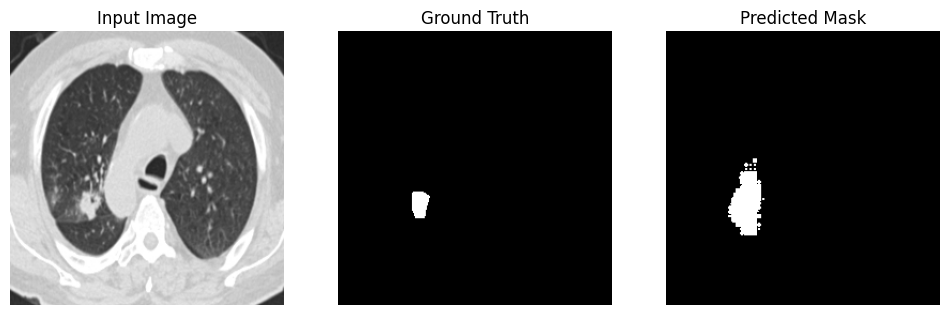

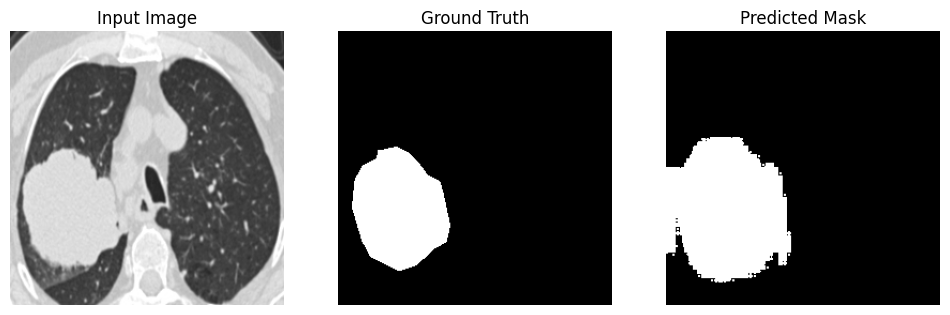

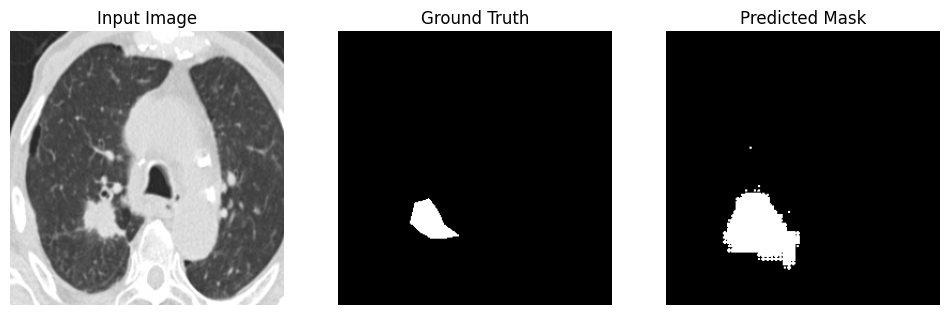

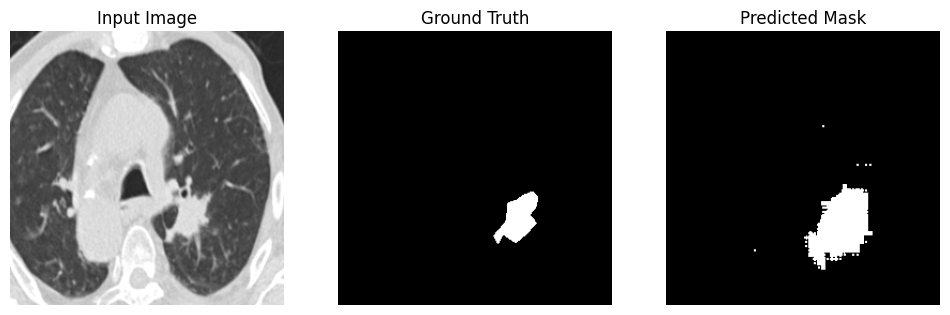

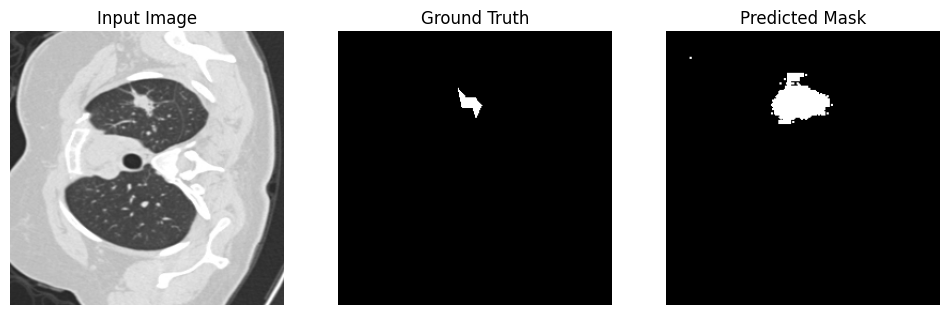

In [ ]:
evaluate_on_samples(model, dataset, device, num_samples=5)

In [ ]:
# Save model weights
torch.save(model.state_dict(), "qrc_unet_trained.pth")

In [19]:
from google.colab import files
files.download("qrc_unet_trained.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>